In [1]:
from model import RadarCamModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from nuscenes.utils.geometry_utils import view_points
import copy

In [2]:
# Data location
PATH_RELATIVE_DEPTHMAP = "/ssd/Datasets_and_code/nuscenes_depth_estimation/dataset/dataset_radar_cam/relative_depth/00100_rel_depth.npy"
PATH_RADAR = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_radar_pc.txt"
PATH_LIDAR = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_lidar_pc.txt"
PATH_CAM_MATRIX = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_cam_matrix.txt"
MODEL_PATH = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/algorithm/results/2024-06-20_15-22-48/model_4.pth"

In [3]:
# MODEL PARAMETERS
W_ORIGINAL = 1600
H_ORIGINAL = 900
W_NN = 800
H_NN = 450
NUMBER_RADAR_POINTS = 100
MIN_DIST = 0.0
MAX_DIST = 50.0
RADAR_CHANNELS_ENCODER = [64, 128, 256, 432] 
UNET_CHANNELS_IMG = [2, 4, 8, 12, 16, 24, 32, 48] 
UNET_CHANNELS_RADAR = 24

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

model = RadarCamModel(RADAR_CHANNELS_ENCODER, UNET_CHANNELS_IMG, UNET_CHANNELS_RADAR).to(device)
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))

Using device:  cuda


<All keys matched successfully>

In [5]:
# Load data
rel_depth = np.load(PATH_RELATIVE_DEPTHMAP)
radar = np.loadtxt(PATH_RADAR)
lidar = np.loadtxt(PATH_LIDAR)
K = np.loadtxt(PATH_CAM_MATRIX)

In [6]:
# Adapt data

# Rel depthmap
rel_depth = resize(rel_depth, (H_NN, W_NN), order=1, preserve_range=True, anti_aliasing=False)
rel_depth = 1-rel_depth

# Radar
scale_factor_w = W_NN/W_ORIGINAL
scale_factor_h = H_NN/H_ORIGINAL
K[0][0] *= scale_factor_w
K[1][1] *= scale_factor_h
K[0][2] *= scale_factor_w
K[1][2] *= scale_factor_h

# Grab the depths (camera frame z axis points away from the camera).
depths = radar[2, :]
# Take the actual picture (matrix multiplication with camera-matrix + renormalization).
points = view_points(radar, K, normalize=True)
# We change the third dimension (which is 1 after renormalization) to the depth
points[2, :] = depths

# Eliminate points outside the ranges
mask = np.ones(depths.shape[0], dtype=bool)
mask = np.logical_and(mask, depths > MIN_DIST)
mask = np.logical_and(mask, depths < MAX_DIST)
mask = np.logical_and(mask, points[0, :] > 1)
mask = np.logical_and(mask, points[0, :] < W_NN - 1)
mask = np.logical_and(mask, points[1, :] > 1)
mask = np.logical_and(mask, points[1, :] < H_NN - 1)
points = points[:, mask]

radar_projected = copy.deepcopy(points)

points[0,:] /= W_NN
points[1,:] /= H_NN
points[2, :] = (points[2, :] - MIN_DIST) / (MAX_DIST - MIN_DIST)

radar_adapted = points

# Now we resample the radar array to have fixed self.number_radar_points
num_points = radar_adapted.shape[1]
if num_points >= NUMBER_RADAR_POINTS:
    # If the initial pointcloud has more points, select target_size points without replacement
    selected_indices = np.random.choice(num_points, size=NUMBER_RADAR_POINTS, replace=False)
    radar_adapted = radar_adapted[:, selected_indices]
else:
    # If the initial pointcloud has less points, randomly sample with replacement until filling target_size
    selected_indices = np.random.choice(num_points, size=NUMBER_RADAR_POINTS - num_points, replace=True)
    radar_adapted = np.hstack([radar_adapted, radar_adapted[:, selected_indices]])

In [7]:
with torch.no_grad():
    # Perform inference
    rel_depth_torch, radar_adapted_torch = torch.from_numpy(rel_depth).to(device, dtype=torch.float), torch.from_numpy(radar_adapted).to(device, dtype=torch.float)
    rel_depth_torch = rel_depth_torch.unsqueeze(0).unsqueeze(0)
    radar_adapted_torch = radar_adapted_torch.unsqueeze(0)
    output = model(rel_depth_torch, radar_adapted_torch)
    output_cpu = output.cpu().squeeze()
    output_cpu = output_cpu * (MAX_DIST - MIN_DIST) + MIN_DIST
    

(-0.5, 799.5, 449.5, -0.5)

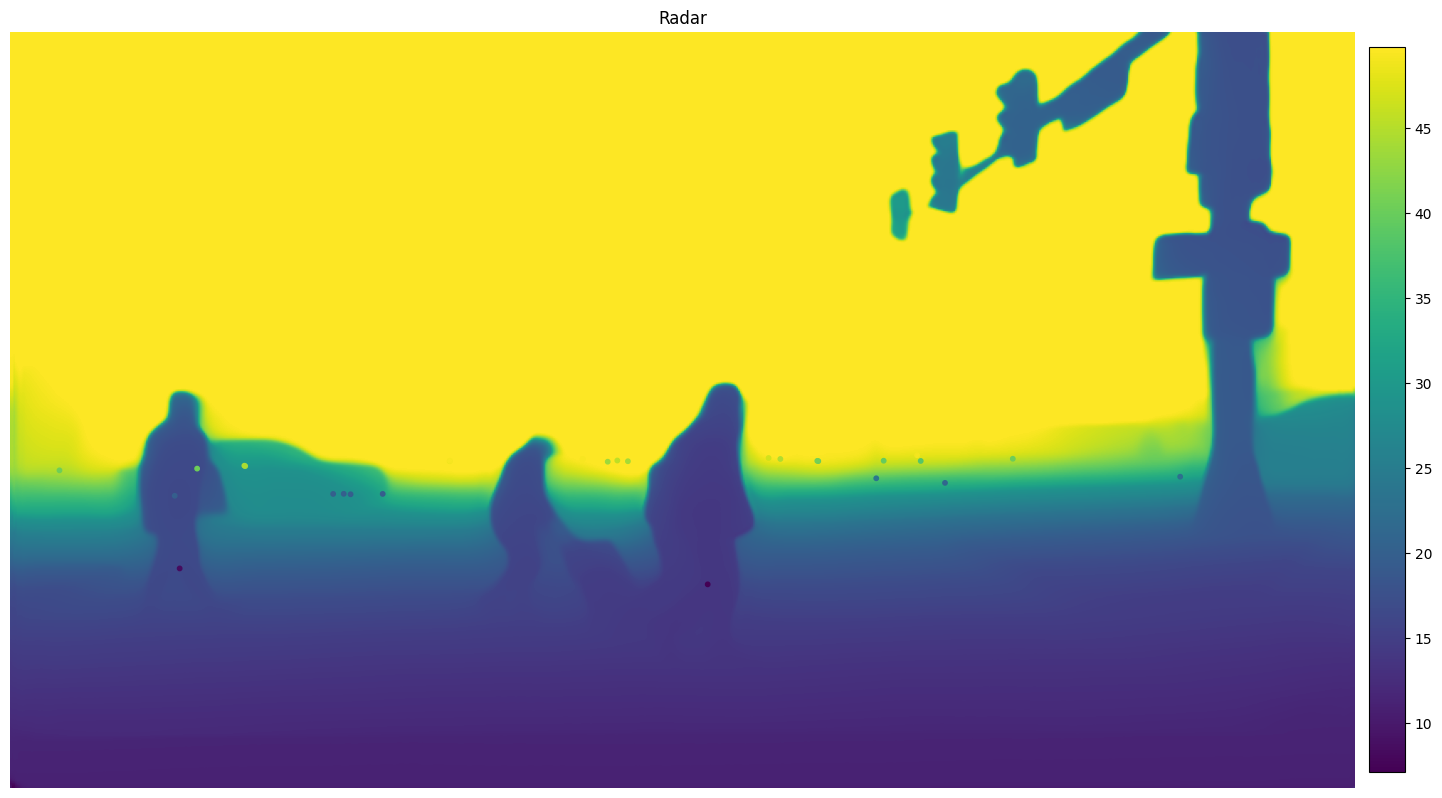

In [8]:
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(18, 32))
# Radar plot
ax.set_title('Radar')
radar_picture = ax.scatter(radar_projected[0,:], radar_projected[1,:], c=radar_projected[2,:], cmap='viridis', s=10)
fig.colorbar(radar_picture, ax=ax, fraction=0.026, pad=0.01)
ax.imshow(output_cpu, alpha=1.0, cmap='viridis')
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

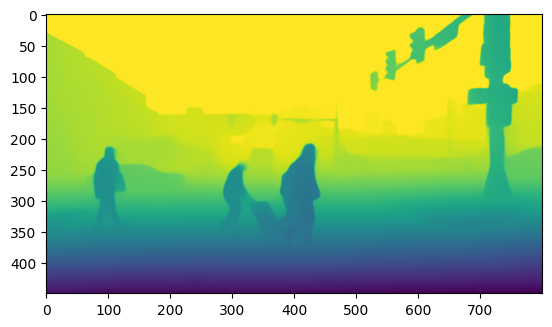

In [9]:
plt.imshow(rel_depth, cmap='viridis')